## Generative Adversarial Networks - GANs




In this lab, we are going to review the concept of GANs, and build a GAN capable of generating digit images!

The main purpose for the GANs is to create data from scratch. GANs are being used to generate the most variated types of data, including music, voice and images.

GANs were first introduced back in 2014 by a group of researchers at the University of Montreal, lead by Ian Goodfellow. The main idea behind them is to have two competing neural networks ( that's why they are called adversarial ). One of them, called the generator, generates samples, and the other one, called the discriminator, receives samples of data from both the generator and the training data, and has to be able to distinguish between them. These two networks engage in a continuous game, where the generator tries to fool the discrimator by learning to produce more realistic samples, and the discriminator tries to get better at distinguishing generated data from real data. The fierce competition between the two networks forces both of them to get better and better at every iteration, and hopefully, get to the point where the generator will generate samples that are indistinguishable from real data. 

### Architecture

Let's start with the generator. The generator uses upsampling layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1 ( which is the size of the MNIST images).

In [1]:
import tensorflow
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, UpSampling2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose,Flatten
from tensorflow.keras.models import Model
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

generator = tensorflow.keras.Sequential()
generator.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Reshape((7, 7, 256)))
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

Using TensorFlow backend.


The generator is still untrained, so it should be pretty bad at generating a digit image. Let's try to generate one and see how it looks like:

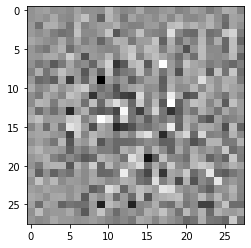

In [2]:
noise = tensorflow.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Now, let's write the discriminator. The discriminator's job is to tell if the image generated by the generator is a digit or not, and since it is an image classification task, why not use a convolutional classifier?

In [3]:
discriminator = tensorflow.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

### Loss functions

Now that our architecture is completed, we need to create the loss functions, both for the generator and the discriminator so they can learn from each other. 

In [4]:
cross_entropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on generated images to an array of 0s.

In [5]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tensorflow.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tensorflow.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [6]:
def generator_loss(fake_output):
    return cross_entropy(tensorflow.ones_like(fake_output), fake_output)

### Training

Now let's train our models! You will be able to see the generated images getting better at each epoch of the training process, and in the end, we will combine all of the images of every step into an animated GIF so you can see how it improved over the time. Let's do that by loading the necessary packages and the MNIST dataset.

In [7]:
import glob
import imageio
import numpy as np
import os
import PIL
import time

from IPython import display

## Two different optimizers because we want to train the netorks separately
generator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)

## Let's load the MNIST dataset
(train_images, train_labels), (_, _) = tensorflow.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tensorflow.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### The learning function

Then, we need to define our learning function. The generator receives a random seed as input, and uses that to generate an image. Then, the discriminator is used to classify real images from the mnist dataset, and the images generated by the generator. Then, the losses are calculated for both of them, and the gradients are applied. 

In [8]:
# You can play around with these parameters. Lowering the number of epochs will lead to lower quality in the generated images.

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 12
seed = tensorflow.random.normal([num_examples_to_generate, noise_dim])

@tensorflow.function
def train_step(images):
    
    # Generate the seed which will be used by the discriminator to generate the images
    noise = tensorflow.random.normal([BATCH_SIZE, noise_dim])

    with tensorflow.GradientTape() as gen_tape, tensorflow.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # Calculating the losses
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # The reason why we have multiple optimizers. Here is where the gradients are applied, and both models learn
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### The train function

Now, we need a train function to actually start the learning process. It is very simple, It runs a loop for the amount of epochs specified above, calls our train_step function to train both our generator and discriminator, and calls a helper function that saves our generated images so we can create a GIF image after the training process is completed.

In [9]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('generated-images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Training our models.

Then we can call our train function and see the generated images getting better at every epoch.

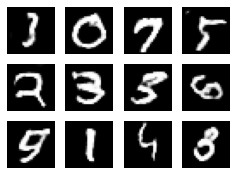

In [10]:
train(train_dataset, EPOCHS)

### Seeing the final result

Now we can convert all of the generated images into an animated GIF so we can see the generated images getting better over the epochs.

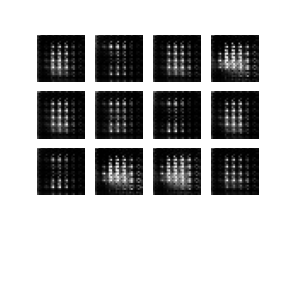

In [14]:
anim_file = 'generated-images/result.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated-images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

display.Image(filename=anim_file)